In [1]:
import cv2
import math
import numpy as np
import skimage.morphology
from matplotlib import pyplot as plt
from skimage.morphology import convex_hull_image, erosion
from skimage.morphology import square

## Code

### Minutiae Feature Class

In [2]:
class MinutiaeFeature():
	def __init__(self, locX, locY, Orientation, Type):
		self.locX = locX
		self.locY = locY
		self.Orientation = Orientation
		self.Type = Type

	def __repr__(self) -> str:
		return f"MinutiaeFeature({self.locX}, {self.locY}, {self.Orientation}, {self.Type})"

	def getPos(self):
		return np.array((self.locX, self.locY))

### Fingerprint Class

In [55]:
class Fingerprint():
	def __init__(self, image, invert=True):
		self.image = image
		self.mask = []
		self.skel = []
		self._minutiaeTerm = []
		self._minutiaeBif = []
		self._spuriousMinutiaeThresh = 10
		self.features = None

		self.extractMinutiaeFeatures(invert)

	def __skeletonize(self, img):
		img = np.uint8(img > 128)
		self.skel = skimage.morphology.skeletonize(img)
		self.skel = np.uint8(self.skel) * 255
		self.mask = img * 255

	def __getTerminationBifurcation(self):
		self.skel = self.skel == 255
		(rows, cols) = self.skel.shape
		self._minutiaeTerm = np.zeros(self.skel.shape)
		self._minutiaeBif = np.zeros(self.skel.shape)

		for i in range(1, rows - 1):
			for j in range(1, cols - 1):
				if (self.skel[i][j] == 1):
					block = self.skel[i - 1:i + 2, j - 1:j + 2]
					block_val = np.sum(block)
					if (block_val == 2):
						self._minutiaeTerm[i, j] = 1
					elif (block_val == 4):
						self._minutiaeBif[i, j] = 1

		self.mask = convex_hull_image(self.mask > 0)
		self.mask = erosion(self.mask, square(5))  # Structuing element for mask erosion = square(5)
		self._minutiaeTerm = np.uint8(self.mask) * self._minutiaeTerm

	def removeSpuriousMinutiae(self, minutiaeList, img):
		img = img * 0
		SpuriousMin = []
		numPoints = len(minutiaeList)
		D = np.zeros((numPoints, numPoints))
		for i in range(1,numPoints):
			for j in range(0, i):
				(X1,Y1) = minutiaeList[i]['centroid']
				(X2,Y2) = minutiaeList[j]['centroid']

				dist = np.sqrt((X2-X1)**2 + (Y2-Y1)**2)
				D[i][j] = dist
				if(dist < self._spuriousMinutiaeThresh):
					SpuriousMin.append(i)
					SpuriousMin.append(j)

		SpuriousMin = np.unique(SpuriousMin)
		for i in range(0,numPoints):
			if(not i in SpuriousMin):
				(X,Y) = np.int16(minutiaeList[i]['centroid'])
				img[X,Y] = 1

		img = np.uint8(img)
		return(img)

	def cleanMinutiae(self, img):
		self._minutiaeTerm = skimage.measure.label(self._minutiaeTerm, connectivity=2)
		RP = skimage.measure.regionprops(self._minutiaeTerm)
		self._minutiaeTerm = self.removeSpuriousMinutiae(RP, np.uint8(img))

	def __computeAngle(self, block, minutiaeType):
		angle = []
		(blkRows, blkCols) = np.shape(block)
		CenterX, CenterY = (blkRows - 1) / 2, (blkCols - 1) / 2
		if (minutiaeType.lower() == 'termination'):
			sumVal = 0
			for i in range(blkRows):
				for j in range(blkCols):
					if ((i == 0 or i == blkRows - 1 or j == 0 or j == blkCols - 1) and block[i][j] != 0):
						angle.append(-math.degrees(math.atan2(i - CenterY, j - CenterX)))
						sumVal += 1
						if (sumVal > 1):
							angle.append(float('nan'))
			return (angle)

		elif (minutiaeType.lower() == 'bifurcation'):
			(blkRows, blkCols) = np.shape(block)
			CenterX, CenterY = (blkRows - 1) / 2, (blkCols - 1) / 2
			angle = []
			sumVal = 0
			for i in range(blkRows):
				for j in range(blkCols):
					if ((i == 0 or i == blkRows - 1 or j == 0 or j == blkCols - 1) and block[i][j] != 0):
						angle.append(-math.degrees(math.atan2(i - CenterY, j - CenterX)))
						sumVal += 1
			if (sumVal != 3):
				angle.append(float('nan'))
			return (angle)

	def performFeatureExtraction(self):
		FeaturesTerm = []
		self._minutiaeTerm = skimage.measure.label(self._minutiaeTerm, connectivity=2)
		RP = skimage.measure.regionprops(np.uint8(self._minutiaeTerm))

		WindowSize = 2  # --> For Termination, the block size must can be 3x3, or 5x5. Hence the window selected is 1 or 2
		FeaturesTerm = []
		for num, i in enumerate(RP):
			(row, col) = np.int16(np.round(i['Centroid']))
			block = self.skel[row - WindowSize:row + WindowSize + 1, col - WindowSize:col + WindowSize + 1]
			angle = self.__computeAngle(block, 'Termination')
			if(len(angle) == 1):
				FeaturesTerm.append(MinutiaeFeature(row, col, angle, 'Termination'))

		FeaturesBif = []
		self._minutiaeBif = skimage.measure.label(self._minutiaeBif, connectivity=2)
		RP = skimage.measure.regionprops(np.uint8(self._minutiaeBif))
		WindowSize = 1  # --> For Bifurcation, the block size must be 3x3. Hence the window selected is 1
		for i in RP:
			(row, col) = np.int16(np.round(i['Centroid']))
			block = self.skel[row - WindowSize:row + WindowSize + 1, col - WindowSize:col + WindowSize + 1]
			angle = self.__computeAngle(block, 'Bifurcation')
			if(len(angle) == 3):
				FeaturesBif.append(MinutiaeFeature(row, col, angle, 'Bifurcation'))
		return (FeaturesTerm, FeaturesBif)

	def extractMinutiaeFeatures(self, invert):
		if (invert):
			self.image = 255 - self.image

		self.__skeletonize(self.image)

		self.__getTerminationBifurcation()

		self.cleanMinutiae(self.image)

		FeaturesTerm, FeaturesBif = self.performFeatureExtraction()
		self.features = np.concatenate((FeaturesTerm, FeaturesBif))
		

### Misc

In [40]:
def drawFeatures(img, featuresArray):
	(rows, cols) = img.shape
	DispImg = np.zeros((rows, cols, 3), np.uint8)
	DispImg[:, :, 0] = 255*img
	DispImg[:, :, 1] = 255*img
	DispImg[:, :, 2] = 255*img

	for i, features in enumerate(featuresArray):
		for idx, curr_minutiae in enumerate(features):
			row, col = int(curr_minutiae.locX), int(curr_minutiae.locY)
			(rr, cc) = skimage.draw.circle_perimeter(row, col, 3)

			if (curr_minutiae.Type == 'Termination'):
				skimage.draw.set_color(DispImg, (rr, cc), (0, 255, 255/len(featuresArray)*(i+1)))

			elif (curr_minutiae.Type == 'Bifurcation'):
				skimage.draw.set_color(DispImg, (rr, cc), (255, 0, 255/len(featuresArray)*(i+1)))

	plt.imshow(DispImg)
	plt.axis('off')
	plt.show()

### Feature Matcher Class

In [63]:
import copy


class FeatureMatcher:
	def __init__(self):
		query = None
		self.template = None

	def __scale(self, minutiae, scale):
		for m in minutiae:
			m.locX *= scale
			m.locY *= scale
		return minutiae

	def __rotate(self, minutiae, rotation):
		# Rotate minutiae by rotation radians
		for m in minutiae:
			m.locX = m.locX * np.cos(rotation) - m.locY * np.sin(rotation)
			m.locY = m.locX * np.sin(rotation) + m.locY * np.cos(rotation)
		return minutiae

	def __translate(self, minutiae, shiftx, shifty):
		for m in minutiae:
			m.locX += shiftx
			m.locY += shifty
		return minutiae

	def doTransformation(self, minutiae, scale, rotation, shiftx, shifty):
		minutiae = copy.deepcopy(minutiae)
		minutiae = self.__scale(minutiae, scale)
		minutiae = self.__rotate(minutiae, rotation)
		minutiae = self.__translate(minutiae, shiftx, shifty)
		return minutiae

	def __numMatches(self, shiftx, shifty, rotation, scale):
		# Do the transformations on the query
		query = self.doTransformation(self.query, scale, rotation, shiftx, shifty)

		# Find distance between each minutiae in template and query
		distMat = np.zeros((len(query), len(self.template)))
		for i in range(len(query)):
			for j in range(len(self.template)):
				distMat[i, j] = (np.linalg.norm(query[i].getPos() - self.template[j].getPos()))
		# Find the minimum distance for each minutiae in query
		minDists = np.min(distMat, axis=1)
		# Find MSE
		# mse = np.mean(minDists ** 2)
		# Find number of matches
		numMatches = np.sum(minDists < 5)

		return numMatches

	def match(self, query, template):
		self.query = query
		self.template = template

		max = 0

		# Search space to find optimal parameters
		for scale in np.linspace(0.8, 1.2, 10):
			for rotation in np.linspace(-np.pi / 12, np.pi / 12, 10):
				for shiftx in np.linspace(-200, 200, 20):
					for shifty in np.linspace(-200, 200, 20):
						matches = self.__numMatches(shiftx, shifty, rotation, scale)

						if matches > max:
							max = matches
							bestShiftx = shiftx
							bestShifty = shifty
							bestRotation = rotation
							bestScale = scale
		
		return max, self.doTransformation(self.query, bestScale, bestRotation, bestShiftx, bestShifty)

## Implementation

In [56]:
q = Fingerprint(cv2.imread('data/DB1_B/101_2.tif', cv2.IMREAD_GRAYSCALE))
t1 = Fingerprint(cv2.imread('data/DB1_B/101_1.tif', cv2.IMREAD_GRAYSCALE))
t2 = Fingerprint(cv2.imread('data/DB1_B/102_1.tif', cv2.IMREAD_GRAYSCALE))

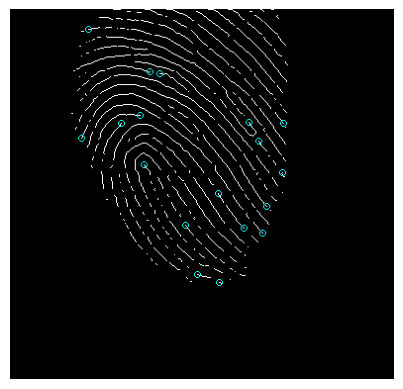

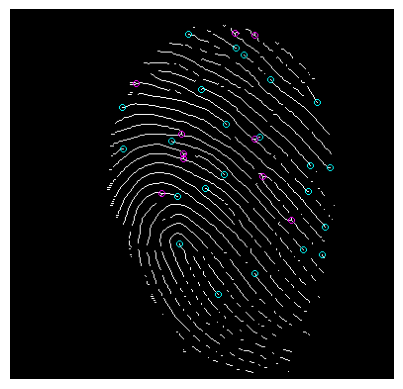

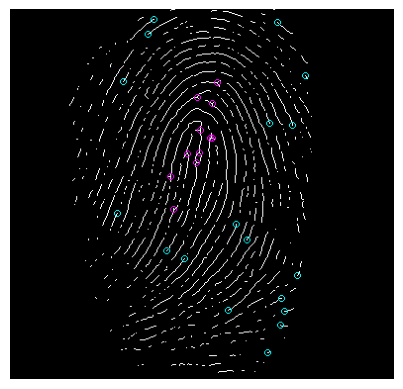

In [57]:
drawFeatures(q.skel, [q.features])
drawFeatures(t1.skel, [t1.features])
drawFeatures(t2.skel, [t2.features])

4


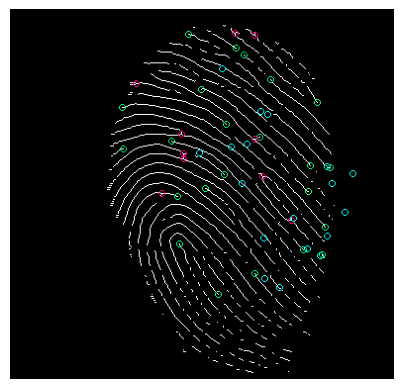

In [67]:
fm = FeatureMatcher()

matches, matchedFeatures = fm.match(q.features, t1.features)
print(matches)
drawFeatures(t1.skel, [t1.features, matchedFeatures])

5


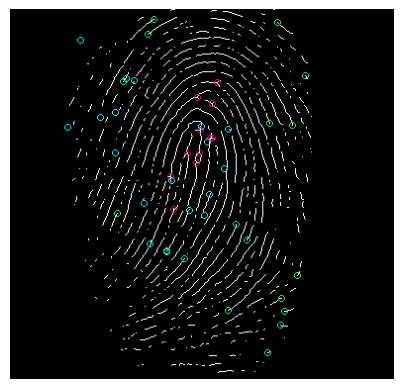

In [66]:
fm = FeatureMatcher()

matches, matchedFeatures = fm.match(q.features, t2.features)
print(matches)
drawFeatures(t2.skel, [t2.features, matchedFeatures])